# Выявление дубликатов названий с использованием частотного анализа и методов похожести строк

## Чтение и исследование данных

In [97]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') 

train = pd.read_csv('data/train.csv', index_col='pair_id')
test = pd.read_csv('data/test.csv', index_col='pair_id')

Смотрим на содержимое таблицы

In [2]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


Смотрим на дубликаты

In [3]:
train[train.is_duplicate==1].head()

,name_1,name_2,is_duplicate
pair_id,,,
162,JX Nippon Oil & Gas Exploration (Brasil) Ltda,JX Nippon Oil & Gas Exploration Technical Serv...,1
604,Pirelli Neumaticos S.A.I.C.,"Pirelli Tyre Co., Ltd.",1
836,Brenntag Australia (Pty) Ltd.,Brenntag Group,1
1329,"PAUL BAUDER GMBH & CO KG, BOCHUM PLANT",Paul Bauder ag,1
1563,TOTAL CESKA REPUBLIKA s.r.o.,TOTAL FRANCE (ARNAY LE DUC),1


Соотношение дубликатов и недубликатов

In [4]:
train.is_duplicate.value_counts()

0    494161
1      3658
Name: is_duplicate, dtype: int64

#### Функция для нормализации названий

Предобработка состоит из следующих этапов:
1. транслитерация - приведение всех символов к латинице (модуль unidecode)
2. приведение текста к нижнему регистру
3. замена всех точек и запятых на пустой символ. Имеет смысл для склеивания типов юридических лиц (P.L.C или S.c.r.l.)
4. замена содержимого скобок на пробел
5. замена небуквенных знаков (кроме цифр) на пробел
6. замена однобуквенных слов на пробел
7. замена лишних пробельных символов (в т.ч. замена табуляций \t)

In [14]:
from unidecode import unidecode
import re

def preprocess(text: str):
    text = unidecode(text)
    text = text.lower()
    text = re.sub(r'[\.,]+', '', text)
    text = re.sub(r"\(.*\)", ' ', text)
    text = re.sub(r"[^\w\s]", ' ', text)
    text = re.sub(r'\b\w\b', ' ', text)
    text = ' '.join(text.split())
    return text

#### Стоп-слова

Выделим стоп-слова, которые часто встречаются в нашей задаче и могут помешать предсказанию. В первую очередь в голову могут прийти названия стран и их сокращения, а также различные типы юридических лиц: ООО, ЗАО и т.д. Для получения названий стран воспользуемся библиотекой pycountry. Также возьмём некоторые аббревиатуры из
<a href="https://en.wikipedia.org/wiki/List_of_legal_entity_types_by_country" target="_blank">списка типов юридических лиц по стране</a>

In [15]:
import pycountry

countries = {'us', 'usa', 'sng', 'uk', 'america', 'americas', 'russia', 'espana', 'nederland', 'polska'}
for country in pycountry.countries:
    name = preprocess(country.name)
    if len(name.split()) == 1:
        countries.add(name)

legal_entities = {"ltd", "co", "inc", "bv", "scrl", "gmbh", "pvt", 'llc', 'ooo', 'gk', 'pt', 'imp', 'exp', 'plc', 'pte', 'srl'}

stopwords = legal_entities | countries

Получим частые слова с помощью Count Vectorizer.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer(preprocessor=preprocess, stop_words=stopwords)
train_vectorized = vector.fit_transform(train.name_1 + ' ' + train.name_2)
train_vectorized

<497819x16241 sparse matrix of type '<class 'numpy.int64'>'
	with 2501069 stored elements in Compressed Sparse Row format>

Видим всего 16241 уникальных слов без приведённых стоп-слов. Посчитаем количество повторений качество и посмотрим на частые слова

In [17]:
counts = np.array(train_vectorized.sum(0))[0]
names = np.array(vector.get_feature_names())

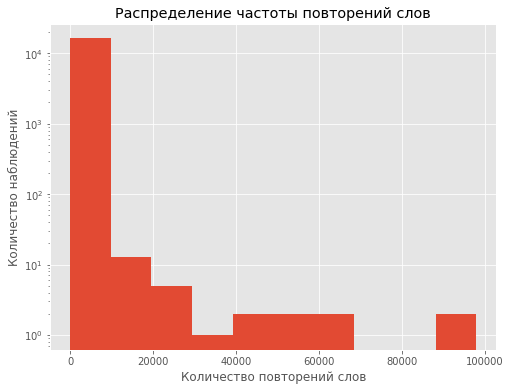

In [30]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(8,6))
plt.hist(counts, log=True)
plt.title('Распределение частоты повторений слов')
plt.xlabel('Количество повторений слов')
plt.ylabel('Количество наблюдений');

Видим, что есть очень частые слова (около 100 000 повторений), которые не относятся к названию компаний и будут мешать предсказанию. В то же время нельзя наверняка сказать, что если какое-то слово встречается очень часто, то оно будет стоп-словом. Визуализируем частые слова с помощью библиотеки wordcloud

In [19]:
name2cnt = {name:count for name, count in zip(names, counts)}

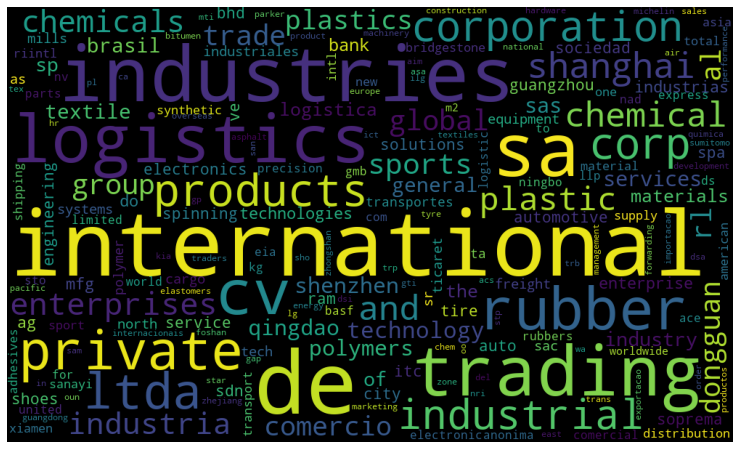

In [20]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1000, height=600, random_state=0).generate_from_frequencies(name2cnt)

plt.figure(figsize=(13, 10))
plt.imshow(wordcloud)
plt.axis('off');

Видим очевидные слова, от которых надо избавиться: international, private, trading и так далее. Но в то же время встречаются названия компаний. Например, Soprema (3297 повторений), Bridgestone (2754), basf (2164) и т. д.  
Добавим в список стоп-слов частые слова, которые не относятся к названию предприятия. Выберем порог частоты в 3300

In [21]:
frequent_words = names[counts > 3300]
frequent_words

array(['ag', 'al', 'and', 'auto', 'automotive', 'bank', 'bhd', 'brasil',
       'chemical', 'chemicals', 'city', 'comercio', 'corp', 'corporation',
       'cv', 'de', 'do', 'dongguan', 'electronics', 'engineering',
       'enterprise', 'enterprises', 'general', 'global', 'group',
       'guangzhou', 'industria', 'industrial', 'industrias', 'industries',
       'industry', 'international', 'itc', 'logistica', 'logistics',
       'ltda', 'materials', 'mfg', 'of', 'plastic', 'plastics',
       'polymers', 'private', 'products', 'qingdao', 'ram', 'rl',
       'rubber', 'sa', 'sas', 'sdn', 'service', 'services', 'shanghai',
       'shenzhen', 'shoes', 'solutions', 'sp', 'spa', 'sports',
       'technologies', 'technology', 'textile', 'the', 'tire', 'trade',
       'trading', 've'], dtype='<U50')

In [22]:
stopwords = stopwords | set(frequent_words)

Применим предобработку: нормализуем названия и избавимся от стоп-слов

In [132]:
train[['name_1', 'name_2']] = train[['name_1', 'name_2']].applymap(preprocess)

In [133]:
def del_stopwords(text: str, stopwords=stopwords):
        return ' '.join([i for i in text.split() if i not in stopwords if i != ''])
    
train[['name_1', 'name_2']] = train[['name_1', 'name_2']].applymap(del_stopwords)

### Функции для извлечения признаков

* `first_n` количество совпадающий первых букв  
* `first_n_fraq` отношение first_n к суммарной длине названий  
* `word_ol` количество пересекающихся слов   
* `word_uni` количество уникальных слов в двух названиях  
* `word_jakar` отношение word_ol к word_uni
* `is_subset` содержит ли одно названия все слова другого или наоборот
* `last_n` аналогично first_n, только считаются последние буквы
* `word_diff` модуль разницы в количестве слов
* `len_diff` модуль разницы в длине названий
* `is_substr` аналогично is_subset, только учитывается порядок слов

In [6]:
def first_n(a, b):
    a = re.sub('\s', '', a)
    b = re.sub('\s', '', b)
    idx = 0
    minlen = min(len(a), len(b))
    while idx < minlen and a[idx] == b[idx]:
        idx += 1
    return idx


def first_n_fraq(a, b):
    return first_n(a, b) / (len(a) + len(b) + 1e-8)


def word_ol(a, b):
    a = set(a.split())
    b = set(b.split())
    return len(a & b)


def word_uni(a, b):
    a = set(a.split())
    b = set(b.split())
    return len(a | b)


def word_jakar(a, b):
    inter = word_ol(a, b)
    union = word_uni(a, b)
    return inter / (union + 1e-8)


def is_subset(a, b):
    if a == '' or b == '':
        return False
    a = set(a.split())
    b = set(b.split())
    return a.issubset(b) or b.issubset(a)


def last_n(a, b):
    return first_n(a[::-1], b[::-1])


def word_diff(a, b):
    return abs(len(a.split()) - len(b.split()))


def len_diff(a, b):
    return abs(len(a) - len(b))


def is_substr(a, b):
    if a == '' or b == '':
        return False
    a = sorted(set(a.split()))
    b = sorted(set(b.split()))
    a = ''.join(a)
    b = ''.join(b)
    return a in b or b in a

#### Стандартные метрики вычисления сходства строк из библиотеки strsimpy:
* Levenshtein - это минимальное количество однофамилийных правок (вставок, удалений или замен), необходимых для изменения одного названия на другое.
* JaroWinkler - расстояние для редактирования строк, разработанное в области записи связи (duplicate detection). Метрика, которая была разработана специально для обнаружения опечаток в именах людей. Это может иметь смысл и в нашей задаче
* MetricLCS - нормированная LCS (Longest Common Subsequence), которая ищет самую длинную общую подпоследовательность

In [8]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.jaro_winkler import JaroWinkler
from strsimpy.metric_lcs import MetricLCS

leven = Levenshtein().distance
jaro = JaroWinkler().similarity
metriclcs = MetricLCS().distance

Визуализируем некоторые признаки с разделение на дубликаты и недубликаты. Сделаем в некоторых местах андер семплинг для лучшего восприятия возможных зависимостей

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_relations(X, y, title='', xlabel='', ylabel=''):
    plt.figure(figsize=(10,8))
    plt.title(title)
    plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale('log')
    sns.histplot()
    sns.histplot(X[y.eq(0)], color='red', label='Не дубликаты', alpha=0.3)
    sns.histplot(X[y.eq(1)], label='Дубликаты', alpha=0.7)
    plt.legend();

def plot_count(X, y, title='', xlabel='', ylabel=''):
    y = y.replace({0: 'Не дубликаты', 1: 'Дубликаты'})
    plt.figure(figsize=(10,8))
    sns.countplot(X, hue=y, log=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

def calc_prob(X, y):
    print('вероятность дубликата при', X.name, '== True:' , y[X==1].mean())
    print('вероятность не дубликата при', X.name, '== True:' , y[X==0].mean())

In [134]:
train['first_n'] = train.apply(lambda x: first_n(x.name_1, x.name_2), axis=1)
train['word_jakar'] = train.apply(lambda x: word_jakar(x.name_1, x.name_2), axis=1)
train['is_subset'] = train.apply(lambda x: is_subset(x.name_1, x.name_2), axis=1)
train['word_diff'] = train.apply(lambda x: word_diff(x.name_1, x.name_2), axis=1)

train_us = pd.concat(
    [
        train[train.is_duplicate==0].sample(3700, random_state=0),
        train[train.is_duplicate==1]
    ]
)

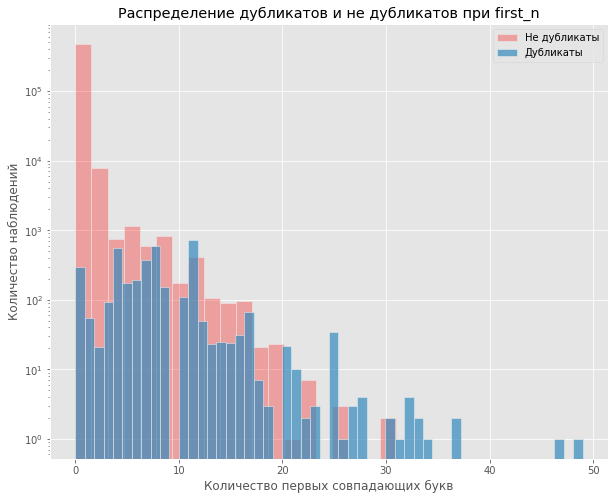

In [135]:
plot_relations(train['first_n'], train['is_duplicate'], 
               title='Распределение дубликатов и не дубликатов при first_n', 
               xlabel='Количество первых совпадающих букв',
               ylabel='Количество наблюдений')

Видим, что чем больше количество первых совпадающих букв в усечённой выборке, тем меньше наблюдений с не дубликатами

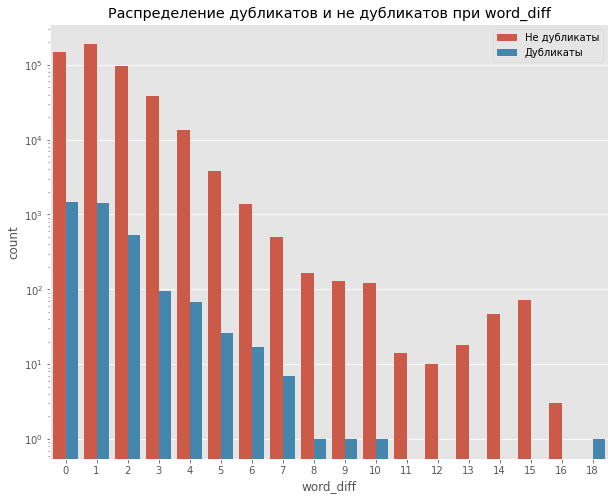

In [219]:
plot_count(train['word_diff'], 
           train['is_duplicate'],
           title='Распределение дубликатов и не дубликатов при word_diff', 
           xlabel='Количество различающихся слов',
           ylabel='Количество наблюдений')

plt.legend(title='', loc='upper right');

Видим, что по мере увелчения количества различающихся слов, уменьшается количество наблюдений с дубликатами. Видим также выброс, при word_diff=18. Данный признак поможет в большей степени для обнаружения не дубликата

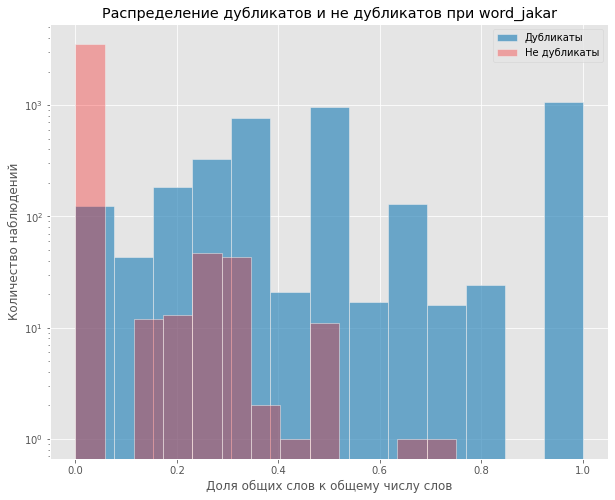

In [222]:
plot_relations(train_us['word_jakar'], train_us['is_duplicate'], 
               title='Распределение дубликатов и не дубликатов при word_jakar', 
               xlabel='Доля общих слов к общему числу слов',
               ylabel='Количество наблюдений')

Можно также заметить, что отношение дубликатов к не дубликатов на усечённой выборке становится больше с увеличением доли общих слов. Также можно заметить, что есть идентичные названия (word_jakar=1.), которые являются дубликатами.

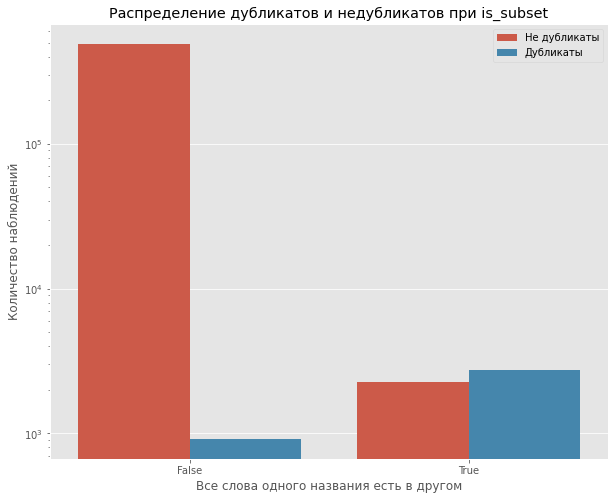

In [231]:
plot_count(train['is_subset'], train['is_duplicate'], 
               title='Распределение дубликатов и недубликатов при is_subset', 
               xlabel='Все слова одного названия есть в другом',
               ylabel='Количество наблюдений')
plt.legend(title='');

Посмотрим на условные вероятности для переменной is_subset

In [223]:
calc_prob(train['is_subset'], train['is_duplicate'])

вероятность дубликата при is_subset == True: 0.5482710373775734
вероятность не дубликата при is_subset == True: 0.0018566767312749586


Видим, что при вероятность дубликата, если все слова одного названия есть в другом, равна 54.8%. В то же время во много раз меньше (~0.002%) наблюдений с is_subset==True, которые можно ошибочно можно посчитать дубликатами

### Импортирование классов пайплайна

Для упорядочивания кода при предобработке и извлечении признаков создадим конвейер. Другими словами, сделаем это всё в один этап. Для этого импортируем написанные раннее классы пайплайна

In [3]:
from transformers import Preprocessor, FeatureExtractor, ColumnDropper

* `Preprocessor` - трансформер, предназначенный для предобработки названий, а также очистки от стоп-слов. Принимает предобработчик preprocess и стоп-слова
* `FeatureExtractor` извлекает признаков из названий. Принимает функции, которые необходимо применить
* `ColumnDropper` удаляет лишние столбцы. Принимает список столбцов, которые надо удалить

In [36]:
funcs = [
         ('first_n', first_n),
         ('is_subset', is_subset),
         ('word_jakar', word_jakar),
         ('first_n_fraq', first_n_fraq),
         ('word_ol', word_ol),
         ('word_uni', word_uni),
         ('last_n', last_n),
         ('word_diff', word_diff),
         ('len_diff', len_diff),
         ('is_substr', is_substr),
         ('leven', leven),
         ('jaro', jaro),
         ('metriclcs', metriclcs),
]

In [24]:
from sklearn.pipeline import make_pipeline

preprocessor = Preprocessor(preprocess, stopwords)
extractor = FeatureExtractor(funcs)
column_dropper = ColumnDropper(['name_1', 'name_2'])

pipe = make_pipeline(
    preprocessor,
    extractor,
    column_dropper
)

In [25]:
train = pd.read_csv('data/train.csv', index_col='pair_id')
X, y = train[['name_1', 'name_2']], train['is_duplicate']
X = pipe.fit_transform(X)

Preprocessing...



Applying functions...


Построим тепловую карту корреляций между получившимися признаками

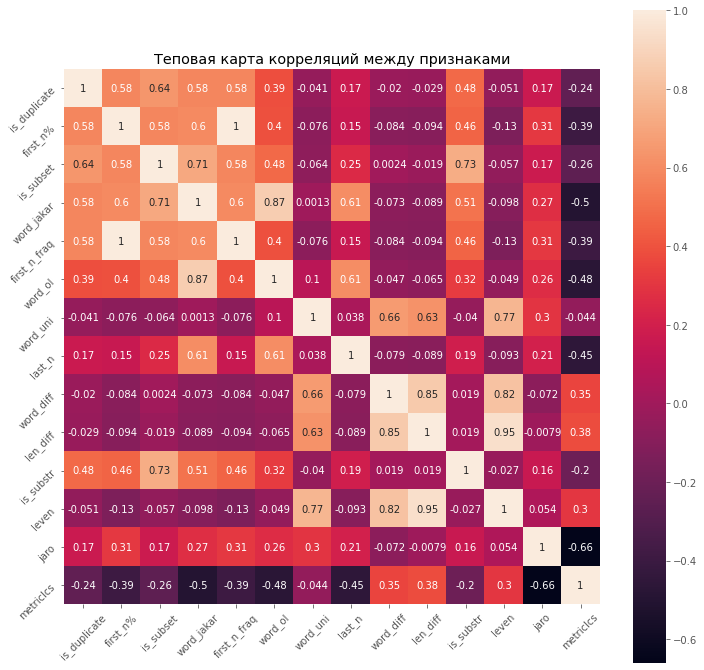

In [35]:
_, ax = plt.subplots(figsize=(12,12))
# ax.tick_params(labelsize=14)
spam = pd.concat([y, X], axis=1)
sns.heatmap(spam.corr(), annot=True, square=True)
plt.title('Теповая карта корреляций между признаками')
plt.xticks(rotation=45)
plt.yticks(rotation=45);

Видим среднюю корреляцию с целевой переменной у некоторых признаков. Также можно заметить, что некоторые признаки коррелируют друг с другом сильнее. Отберем признаки и перейдём к построению модели

In [75]:
funcs = [
         ('first_n%', first_n_fraq),
         ('is_subset', is_subset),
         ('word_jakar', word_jakar),
]

preprocessor = Preprocessor(preprocess, stopwords)
extractor = FeatureExtractor(funcs)
column_dropper = ColumnDropper(['name_1', 'name_2'])

pipe = make_pipeline(
    preprocessor,
    extractor,
    column_dropper
)

### Деление выборки и пропуск выборок через пайплайн

In [76]:
from sklearn.model_selection import train_test_split

X, y = train[['name_1', 'name_2']], train['is_duplicate']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [77]:
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)

Preprocessing...



Applying functions...



Preprocessing...



Applying functions...


В качестве модели будем брать xgboost

In [78]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=0, n_jobs=-1)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Оценим качество модели и подберём пороги

In [79]:
from sklearn.metrics import classification_report, f1_score

y_train_pred = model.predict_proba(X_train)[:, 1]
y_val_pred = model.predict_proba(X_val)[:, 1]

Метрики классификации на валидации

In [80]:
print(classification_report(y_val, y_val_pred.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98832
           1       0.82      0.72      0.77       732

    accuracy                           1.00     99564
   macro avg       0.91      0.86      0.88     99564
weighted avg       1.00      1.00      1.00     99564



Подбор порога

In [81]:
from sklearn.metrics import precision_recall_curve

def get_threshold(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    f = []
    for idx, val in enumerate(thresholds):
        f.append(2 * precision[idx] * recall[idx] / (precision[idx] + recall[idx]))
    THR = thresholds[np.array(f).argmax()]
    return THR

In [82]:
THR = get_threshold(y_train, y_train_pred)

In [83]:
print(classification_report(y_val, y_val_pred > THR))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98832
           1       0.77      0.79      0.78       732

    accuracy                           1.00     99564
   macro avg       0.88      0.90      0.89     99564
weighted avg       1.00      1.00      1.00     99564



Подбор порога особо не повлиял на f-score, но сбалансировал precision и recall

### Инференс

In [98]:
X_test = pipe.transform(test)

Preprocessing...



Applying functions...


In [121]:
test['is_duplicate'] = model.predict_proba(X_test)[:, 1] > THR
test['is_duplicate'] = test['is_duplicate'].astype(int)

Посмотрим на определение дубликатов идентичных названий

In [123]:
test[test.name_1.str.lower() == test.name_2.str.lower()]

,name_1,name_2,is_duplicate
pair_id,,,
19537,"ООО ""ПРОМСНАБПОСТАВКА""","ООО ""ПРОМСНАБПОСТАВКА""",1
27268,"ООО""ТОРГОВЫЙ ДОМ""ДРУГОЙ МИР""","ООО""ТОРГОВЫЙ ДОМ""ДРУГОЙ МИР""",1
31307,INRECO - EMULSJA SP. Z O.O.,INRECO - EMULSJA SP. Z O.O.,1
40478,"ООО""ТЕХНОНИКОЛЬ - СТРОИТЕЛЬНЫЕ СИСТЕМЫ""","ООО""ТЕХНОНИКОЛЬ - СТРОИТЕЛЬНЫЕ СИСТЕМЫ""",1
40965,COLAS Polska Sp. z o.o.,Colas Polska Sp. z o.o.,1
45965,"ООО""ПРЕСТО""","ООО""ПРЕСТО""",1
65794,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ""РОСТВ...","ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ""РОСТВ...",1
66576,"АО""ЗАРА СНГ""","АО""ЗАРА СНГ""",1
103299,"ООО""ПАУЛЬ ХАРТМАНН СИБИРЬ""","ООО""ПАУЛЬ ХАРТМАНН СИБИРЬ""",1


In [124]:
test.is_duplicate.value_counts()

0    212152
1      1097
Name: is_duplicate, dtype: int64

Подготовим сабмит

In [125]:
subm = pd.read_csv('data/sample_submission.csv', index_col='pair_id')

In [126]:
subm['is_duplicate'] = test['is_duplicate']

In [129]:
subm.to_csv('my_submission.csv')

### Заключение

Данный подход дал качество 0.59 на тестовой выборке при чуть большем отсечении частых слов (исключая названия компаний) и подкрутке параметров xgboost. Данный ноутбук создан для ознакомления с идеей решения. Оно основано на тщательной предобработке и эвристических функциях. Его можно улучшить, если учитывать семантику слов: можно учитывать веса слов: если слово в двух названиях совпало и оно полезно (относится к названию компании) - имеет вес, мы автоматически считаем что оно настолько же вредно в "разнице" слов; использование как можно больше внешних данных с названием компаний и т. д. Также не забывать анализировать наблюдения, на которых ошибается модель (False Positive, False Negative), и на основе этого конструировать новые признаки. Успехов!

### Спасибо за внимание!